## Подключение библиотек

In [73]:
import pandas as pd
import numpy as np
import os

%matplotlib inline 
import matplotlib as mpl
import matplotlib.pyplot as plt

np.random.seed=42
mpl.rc('axes', labelsize = 14)
mpl.rc('xtick', labelsize = 12)
mpl.rc('ytick', labelsize = 12)

### Загрузка данных

In [74]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version = 1, cache = True)
mnist.target = mnist.target.astype(np.int8)

In [75]:
def sort_by_target(mnist):
    reorder_train = np.array(sorted([(target,i) for i, target in enumerate(mnist.target[:60000])]))[:, 1]
    reorder_test = np.array(sorted([(target,i) for i, target in enumerate(mnist.target[60000:])]))[:, 1]
    mnist.data[:60000] = mnist.data[reorder_train]
    mnist.target[:60000] = mnist.target[reorder_train]
    mnist.data[60000:] = mnist.data[reorder_test + 60000]
    mnist.target[60000:] = mnist.target[reorder_test + 60000]
    
sort_by_target(mnist)

### Просмотр данных

In [76]:
mnist['data'], mnist['target']

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([0, 0, 0, ..., 9, 9, 9], dtype=int8))

In [77]:
X, y = mnist['data'], mnist['target']
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


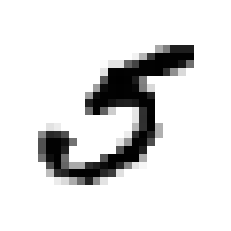

In [78]:
some_digit = X[36000]
some_digit_image = some_digit.reshape(28,28)
plt.imshow(some_digit_image, cmap=mpl.cm.binary, interpolation='nearest')
plt.axis('off')
plt.show()

In [79]:
y[36000]

5

In [80]:
def plot_digit(data):
    image=data.reshape(28,28)
    plt.imshow(image, cmap=mpl.cm.binary, interpolation='nearest')
    plt.axis(False)

In [81]:
def plot_digits(instances,images_per_row=10, **options):
    size=28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap=mpl.cm.binary, **options)
    plt.axis('off')

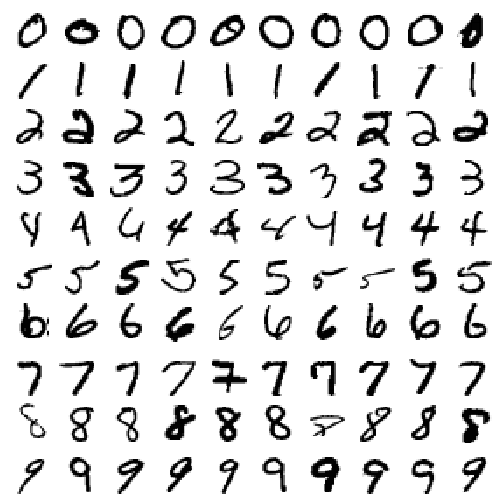

In [82]:
plt.figure(figsize=(9,9))
example_images = np.r_[X[:12000:600], X[13000:30600:600], X[30600:60000:590]]
plot_digits(example_images, images_per_row = 10)
plt.show()

### Создание тестового и испытательного набора

In [83]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [84]:
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

### Обучение Двоичного классификатора

In [85]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [86]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=2)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=2, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [87]:
sgd_clf.predict([some_digit])

array([False])

## Оценка производительности

### Перекрестная проверка

In [88]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train_5[train_index])
    X_test_fold = X_train[test_index]
    y_test_fold = (y_train_5[test_index])
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct/len(y_pred))

0.9633
0.96385
0.9685


In [89]:
from sklearn.model_selection import cross_val_score

#cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

In [90]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
    
never_5_clf = Never5Classifier()
#cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

### Матрица неточностей

In [91]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
y_train_pred

array([False, False, False, ..., False, False, False])

In [92]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53903,   676],
       [ 1411,  4010]], dtype=int64)

### Точность и полнота

In [93]:
from sklearn.metrics import precision_score, recall_score

print(precision_score(y_train_5, y_train_pred))
print(recall_score(y_train_5, y_train_pred))

0.8557405036278276
0.7397159195720346


In [94]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7935094488968042

### Соотношение точность/полнота

In [95]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([-451.11635934])

In [96]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [97]:
threshold = 7000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [98]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')

In [99]:
from sklearn.metrics import precision_recall_curve

precision, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

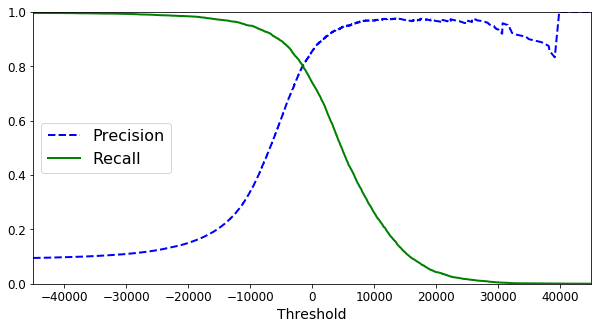

In [100]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='Precision', linewidth=2)
    plt.plot(thresholds, recalls[:-1], 'g-', label='Recall', linewidth=2)
    plt.xlabel('Threshold')
    plt.legend(loc='center left',fontsize=16)
    plt.ylim([0,1])
    plt.xlim([-45000,45000])
    
plt.figure(figsize=(10,5))
plot_precision_recall_vs_threshold(precision, recalls, thresholds)
plt.show()

In [101]:
# Показывает, что для всех распознанных 5-ок количество очков > 0
# а для всех остальных цифр, распознанных как не 5 - количество очков отрицательное.
(y_train_pred == (y_scores > 0)).all()

True

In [102]:
y_train_pred_90 = (y_scores > 1000)
print(precision_score(y_train_5, y_train_pred_90))
print(recall_score(y_train_5, y_train_pred_90))

0.8848753204381263
0.7004242759638443


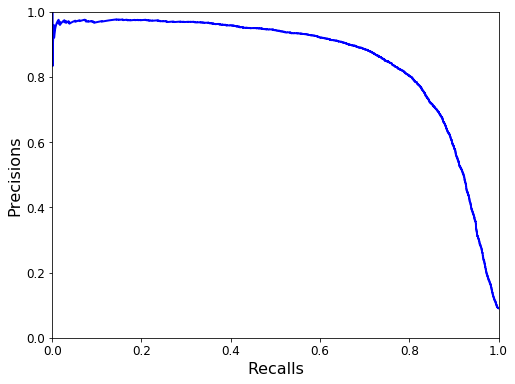

In [103]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, 'b-', linewidth=2)
    plt.xlabel('Recalls', fontsize=16)
    plt.ylabel('Precisions', fontsize=16)
    plt.axis([0, 1, 0, 1])
    
plt.figure(figsize=(8,6))
plot_precision_vs_recall(precision, recalls)
plt.show()

## Кривая ROC

In [104]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

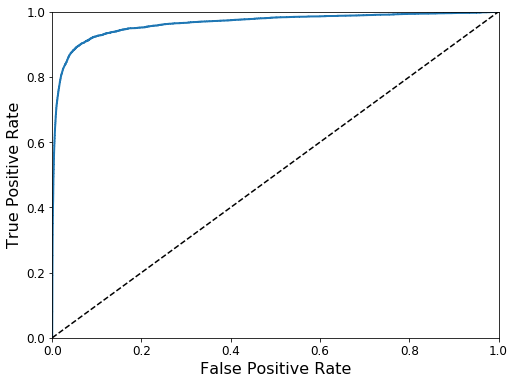

In [105]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    
plt.figure(figsize=(8,6))
plot_roc_curve(fpr, tpr)
plt.show()

In [106]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9643412153398009

In [107]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=2)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict_proba')

In [108]:
y_probas_forest

array([[1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       ...,
       [0.84, 0.16],
       [1.  , 0.  ],
       [1.  , 0.  ]])

In [109]:
y_scores_forest = y_probas_forest[:, 1]
y_scores_forest

array([0.  , 0.  , 0.  , ..., 0.16, 0.  , 0.  ])

In [110]:
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

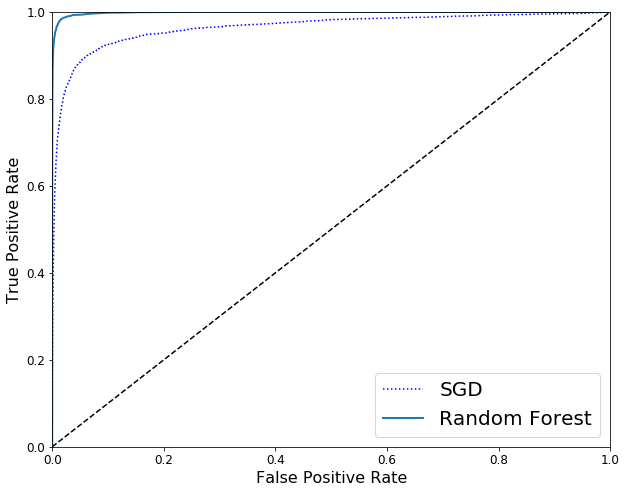

In [111]:
plt.figure(figsize=(10,8))
plt.plot(fpr, tpr, 'b:', label='SGD')
plot_roc_curve(fpr_forest, tpr_forest, 'Random Forest')
plt.legend(loc='lower right', fontsize=20)
plt.axis([0, 1, 0, 1])
plt.show()

In [112]:
roc_auc_score(y_train_5, y_scores_forest)

0.9985631475454623

In [113]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
y_train_pred_forest

array([False, False, False, ..., False, False, False])

In [114]:
print(precision_score(y_train_5, y_train_pred_forest))
print(recall_score(y_train_5, y_train_pred_forest))

0.9896928901977282
0.8679210477771628


In [115]:
#cross_val_score(forest_clf, X_train, y_train_5, cv=3, scoring='accuracy')

In [116]:
forest_clf.fit(X_train, y_train_5)
forest_clf.score(X_train, y_train_5)

1.0

## Многоклассовая классифокация

In [117]:
# Классифаер

sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([5], dtype=int8)

In [118]:
some_digits_scores = sgd_clf.decision_function([some_digit])
some_digits_scores

array([[ -5024.03436203, -26417.25127941,  -7910.12799092,
         -1459.69562593, -14025.21287908,   3332.11804318,
        -25477.15222894, -18650.15636666, -15046.68012732,
        -13476.77731066]])

In [119]:
np.argmax(some_digits_scores)

5

In [120]:
sgd_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int8)

In [121]:
sgd_clf.classes_[5]

5

In [122]:
from sklearn.multiclass import OneVsOneClassifier

ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=2))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array([5], dtype=int8)

In [123]:
len(ovo_clf.estimators_)

45

In [124]:
# Случайные Леса

forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([5], dtype=int8)

In [125]:
print(forest_clf.base_estimator_,
      forest_clf.classes_,
      forest_clf.n_features_,
      forest_clf.n_outputs_, sep='\n')

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
[0 1 2 3 4 5 6 7 8 9]
784
1


In [126]:
print(forest_clf.get_params(),
      forest_clf.predict_proba([some_digit]),
      forest_clf.score(X_train, y_train), sep='\n\n')

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 2, 'verbose': 0, 'warm_start': False}

[[0.06 0.01 0.02 0.04 0.   0.82 0.01 0.02 0.02 0.  ]]

1.0


In [127]:
# Оценочки

#cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy', verbose=6)

In [128]:
#cross_val_score(forest_clf, X_train, y_train, cv=3, scoring='accuracy', verbose=6)

In [129]:
# Масштабирование

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
#cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')

In [130]:
#cross_val_score(forest_clf, X_train_scaled, y_train, cv=3, scoring='accuracy',verbose=6)

## Анализ ошибок

In [131]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_m = confusion_matrix(y_train, y_train_pred)
conf_m

array([[5580,    0,   14,    5,    9,   44,   31,    7,  232,    1],
       [   1, 6409,   47,   17,    3,   45,    4,    6,  200,   10],
       [  26,   25, 5269,   85,   69,   16,   60,   38,  361,    9],
       [  25,   23,  114, 5226,    1,  210,   24,   43,  396,   69],
       [  10,   13,   43,   10, 5206,    7,   34,   22,  345,  152],
       [  27,   15,   29,  151,   53, 4462,   78,   17,  522,   67],
       [  30,   16,   44,    2,   41,   95, 5546,    8,  136,    0],
       [  24,   11,   51,   21,   50,   10,    4, 5691,  193,  210],
       [  18,   64,   40,   98,    0,  116,   27,    6, 5439,   43],
       [  22,   19,   31,   59,  118,   35,    1,  166,  357, 5141]],
      dtype=int64)

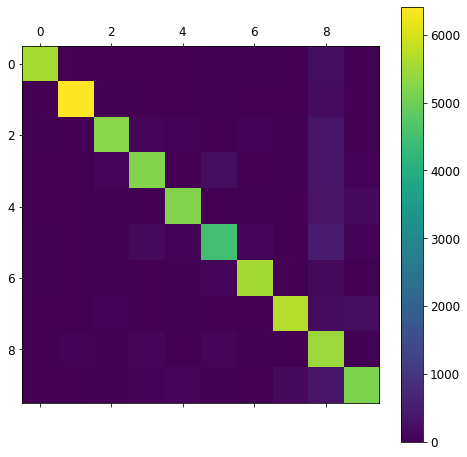

In [132]:
def plot_confusion_matrix(matrix):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
    fig.colorbar(cax)
    
plot_confusion_matrix(conf_m)

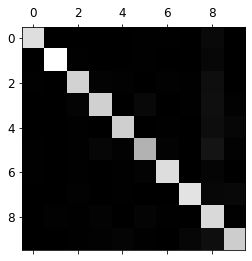

In [133]:
plt.matshow(conf_m, cmap=plt.cm.gray)
plt.show()

In [134]:
row_sums = conf_m.sum(axis=1, keepdims=True)
norm_conf_mx = conf_m / row_sums

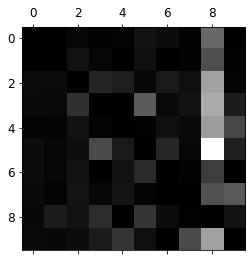

In [135]:
np.fill_diagonal(norm_conf_mx,0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

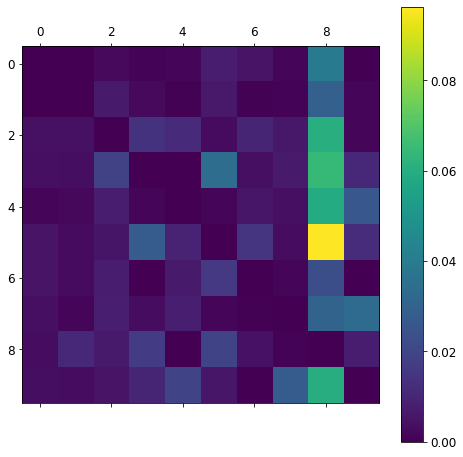

In [136]:
plot_confusion_matrix(norm_conf_mx)

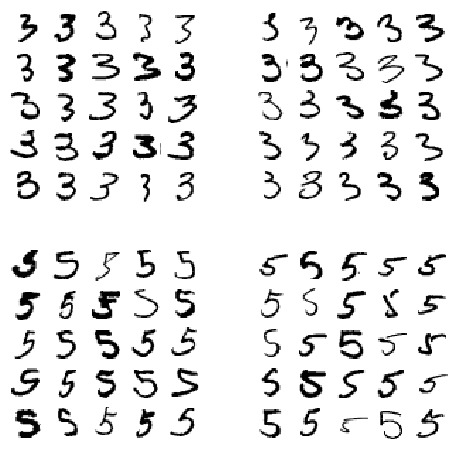

In [137]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

## Многозначная классификация

In [138]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [139]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [140]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3, verbose=6)
f1_score(y_multilabel, y_train_knn_pred, average='macro')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 19.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 39.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 59.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 59.6min finished


0.9771753907506584

## Многовыходовая классификация

In [141]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

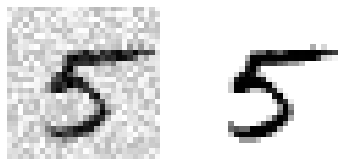

In [142]:
some_index=5500
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
plt.show()

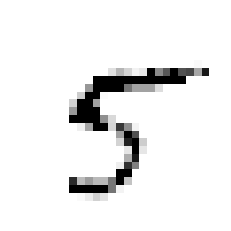

In [143]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)

## Best Clasifier

In [144]:
from sklearn.model_selection import GridSearchCV

knn_clf = KNeighborsClassifier()
params = [
          {'n_neighbors' : [3, 4, 5],
          'weights' : ['uniform', 'distance']},
]

grid_search = GridSearchCV(knn_clf, params, scoring='accuracy', cv=3, verbose=8)
#grid_search.fit(X_train_scaled, y_train)

In [145]:
grid_search.best_params_

In [146]:
grid_search.cv_results_

In [147]:
final_model = grid_search.best_estimator_
final_model

In [148]:
grid_search.best_score_

In [152]:
cvres = grid_search.cv_results_

for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(mean_score, params)

AttributeError: 'GridSearchCV' object has no attribute 'cv_results_'

In [154]:
# Не скалированный набор
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] n_neighbors=3, weights=uniform ..................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ...... n_neighbors=3, weights=uniform, score=0.971, total=19.6min
[CV] n_neighbors=3, weights=uniform ..................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 19.6min remaining:    0.0s


[CV] ...... n_neighbors=3, weights=uniform, score=0.968, total=19.5min
[CV] n_neighbors=3, weights=uniform ..................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 39.0min remaining:    0.0s


[CV] ...... n_neighbors=3, weights=uniform, score=0.971, total=19.5min
[CV] n_neighbors=3, weights=distance .................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 58.6min remaining:    0.0s


[CV] ..... n_neighbors=3, weights=distance, score=0.972, total=19.6min
[CV] n_neighbors=3, weights=distance .................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 78.2min remaining:    0.0s


[CV] ..... n_neighbors=3, weights=distance, score=0.969, total=19.7min
[CV] n_neighbors=3, weights=distance .................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 97.9min remaining:    0.0s


[CV] ..... n_neighbors=3, weights=distance, score=0.973, total=21.3min
[CV] n_neighbors=4, weights=uniform ..................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 119.1min remaining:    0.0s


[CV] ...... n_neighbors=4, weights=uniform, score=0.969, total=20.5min
[CV] n_neighbors=4, weights=uniform ..................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 139.6min remaining:    0.0s


[CV] ...... n_neighbors=4, weights=uniform, score=0.967, total=20.0min
[CV] n_neighbors=4, weights=uniform ..................................
[CV] ...... n_neighbors=4, weights=uniform, score=0.970, total=20.4min
[CV] n_neighbors=4, weights=distance .................................
[CV] ..... n_neighbors=4, weights=distance, score=0.973, total=22.7min
[CV] n_neighbors=4, weights=distance .................................
[CV] ..... n_neighbors=4, weights=distance, score=0.970, total=21.7min
[CV] n_neighbors=4, weights=distance .................................
[CV] ..... n_neighbors=4, weights=distance, score=0.974, total=20.9min
[CV] n_neighbors=5, weights=uniform ..................................
[CV] ...... n_neighbors=5, weights=uniform, score=0.970, total=21.2min
[CV] n_neighbors=5, weights=uniform ..................................
[CV] ...... n_neighbors=5, weights=uniform, score=0.967, total=21.4min
[CV] n_neighbors=5, weights=uniform ..................................
[CV] .

[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed: 369.2min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid=[{'n_neighbors': [3, 4, 5],
                          'weights': ['uniform', 'distance']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=8)

In [155]:
grid_search.best_params_

{'n_neighbors': 4, 'weights': 'distance'}

In [156]:
grid_search.cv_results_

{'mean_fit_time': array([18.86451729, 18.81397955, 18.85575   , 21.54806757, 21.02686119,
        18.75311351]),
 'std_fit_time': array([0.7644298 , 0.13157938, 0.40668867, 1.09620674, 0.76080831,
        0.2655556 ]),
 'mean_score_time': array([1152.74638494, 1191.98325038, 1200.8446095 , 1283.61179884,
        1256.66074602, 1181.0957586 ]),
 'std_score_time': array([ 2.68787011, 45.54388529, 11.84810794, 43.72451643,  4.19618952,
        24.73956229]),
 'param_n_neighbors': masked_array(data=[3, 3, 4, 4, 5, 5],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_weights': masked_array(data=['uniform', 'distance', 'uniform', 'distance',
                    'uniform', 'distance'],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'n_neighbors': 3, 'weights': 'uniform'},
  {'n_neighbors': 3, 'weights': 'distance'},
  {'n_neighbors': 4, 'we

In [157]:
final_model = grid_search.best_estimator_
final_model

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=4, p=2,
                     weights='distance')

In [158]:
grid_search.best_score_

0.9723

In [159]:
cvres = grid_search.cv_results_

for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(mean_score, params)

0.9700833333333333 {'n_neighbors': 3, 'weights': 'uniform'}
0.9714833333333334 {'n_neighbors': 3, 'weights': 'distance'}
0.9685666666666667 {'n_neighbors': 4, 'weights': 'uniform'}
0.9723 {'n_neighbors': 4, 'weights': 'distance'}
0.9690166666666666 {'n_neighbors': 5, 'weights': 'uniform'}
0.9705833333333332 {'n_neighbors': 5, 'weights': 'distance'}


In [160]:
from sklearn.externals import joblib

my_model = grid_search.best_estimator_
joblib.dump(my_model,'my_model.pkl')

['my_model.pkl']

In [161]:
# Рандомные леса

rnd_forest = RandomForestClassifier(random_state=2)

f_params=[
    {'n_estimators':[80, 110, 140, 170, 200, 250, 300, 350, 500],
     'bootstrap':[True, False],
     'class_weight':['balanced', None]}
]

grid_search = GridSearchCV(rnd_forest, f_params, scoring='accuracy', cv=3, verbose=8)
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] bootstrap=True, class_weight=balanced, n_estimators=80 ..........


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  bootstrap=True, class_weight=balanced, n_estimators=80, score=0.967, total=  23.2s
[CV] bootstrap=True, class_weight=balanced, n_estimators=80 ..........


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   23.1s remaining:    0.0s


[CV]  bootstrap=True, class_weight=balanced, n_estimators=80, score=0.964, total=  21.9s
[CV] bootstrap=True, class_weight=balanced, n_estimators=80 ..........


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   45.0s remaining:    0.0s


[CV]  bootstrap=True, class_weight=balanced, n_estimators=80, score=0.965, total=  21.9s
[CV] bootstrap=True, class_weight=balanced, n_estimators=110 .........


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.1min remaining:    0.0s


[CV]  bootstrap=True, class_weight=balanced, n_estimators=110, score=0.968, total=  30.1s
[CV] bootstrap=True, class_weight=balanced, n_estimators=110 .........


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  1.6min remaining:    0.0s


[CV]  bootstrap=True, class_weight=balanced, n_estimators=110, score=0.966, total=  29.9s
[CV] bootstrap=True, class_weight=balanced, n_estimators=110 .........


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.1min remaining:    0.0s


[CV]  bootstrap=True, class_weight=balanced, n_estimators=110, score=0.966, total=  30.1s
[CV] bootstrap=True, class_weight=balanced, n_estimators=140 .........


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  2.6min remaining:    0.0s


[CV]  bootstrap=True, class_weight=balanced, n_estimators=140, score=0.969, total=  37.8s
[CV] bootstrap=True, class_weight=balanced, n_estimators=140 .........


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  3.3min remaining:    0.0s


[CV]  bootstrap=True, class_weight=balanced, n_estimators=140, score=0.966, total=  38.0s
[CV] bootstrap=True, class_weight=balanced, n_estimators=140 .........
[CV]  bootstrap=True, class_weight=balanced, n_estimators=140, score=0.966, total=  38.3s
[CV] bootstrap=True, class_weight=balanced, n_estimators=170 .........
[CV]  bootstrap=True, class_weight=balanced, n_estimators=170, score=0.968, total=  46.2s
[CV] bootstrap=True, class_weight=balanced, n_estimators=170 .........
[CV]  bootstrap=True, class_weight=balanced, n_estimators=170, score=0.966, total=  46.7s
[CV] bootstrap=True, class_weight=balanced, n_estimators=170 .........
[CV]  bootstrap=True, class_weight=balanced, n_estimators=170, score=0.966, total=  47.2s
[CV] bootstrap=True, class_weight=balanced, n_estimators=200 .........
[CV]  bootstrap=True, class_weight=balanced, n_estimators=200, score=0.968, total=  55.4s
[CV] bootstrap=True, class_weight=balanced, n_estimators=200 .........
[CV]  bootstrap=True, class_weight

[CV]  bootstrap=False, class_weight=balanced, n_estimators=110, score=0.971, total=  49.5s
[CV] bootstrap=False, class_weight=balanced, n_estimators=140 ........
[CV]  bootstrap=False, class_weight=balanced, n_estimators=140, score=0.972, total= 1.1min
[CV] bootstrap=False, class_weight=balanced, n_estimators=140 ........
[CV]  bootstrap=False, class_weight=balanced, n_estimators=140, score=0.970, total= 1.1min
[CV] bootstrap=False, class_weight=balanced, n_estimators=140 ........
[CV]  bootstrap=False, class_weight=balanced, n_estimators=140, score=0.971, total= 1.2min
[CV] bootstrap=False, class_weight=balanced, n_estimators=170 ........
[CV]  bootstrap=False, class_weight=balanced, n_estimators=170, score=0.973, total= 1.3min
[CV] bootstrap=False, class_weight=balanced, n_estimators=170 ........
[CV]  bootstrap=False, class_weight=balanced, n_estimators=170, score=0.970, total= 1.4min
[CV] bootstrap=False, class_weight=balanced, n_estimators=170 ........
[CV]  bootstrap=False, class

[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed: 150.3min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=2,
                                   

In [162]:
grid_search.best_params_

{'bootstrap': False, 'class_weight': 'balanced', 'n_estimators': 170}

In [163]:
grid_search.cv_results_

{'mean_fit_time': array([ 21.6355234 ,  29.14594086,  36.89740078,  45.30557728,
         53.41115125,  66.04669038,  80.58688577,  96.56578994,
        131.1270407 ,  24.99142504,  34.30481426,  43.33598185,
         47.20090564,  55.56536627,  69.8559552 ,  79.78335277,
         91.92845647, 138.00729314,  38.40524014,  50.35002979,
         65.12642932,  81.31356072,  87.81304328, 108.67168482,
        134.95265841, 165.21085572, 220.78256965,  32.32022381,
         43.98378499,  55.77349623,  67.73051651,  79.39199424,
         99.80207022, 119.12840708, 139.02190542, 198.72983058]),
 'std_fit_time': array([0.59972261, 0.10897995, 0.2049732 , 0.39726162, 0.54013452,
        0.55214678, 0.24016464, 2.97527426, 3.42243739, 0.32651395,
        0.40025953, 0.13542973, 2.29261622, 1.78389882, 1.35655836,
        1.42038283, 0.98717081, 4.85719922, 2.77189103, 1.78159703,
        4.27870109, 2.21704158, 0.68128251, 1.11801196, 3.30514728,
        9.73125057, 4.1893303 , 0.05981949, 0.062

In [164]:
grid_search.best_score_

0.9715666666666666

In [165]:
final_model = grid_search.best_estimator_
final_model

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=170,
                       n_jobs=None, oob_score=False, random_state=2, verbose=0,
                       warm_start=False)

In [166]:
cvres = grid_search.cv_results_

for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(mean_score, params)

0.9653166666666667 {'bootstrap': True, 'class_weight': 'balanced', 'n_estimators': 80}
0.9666166666666666 {'bootstrap': True, 'class_weight': 'balanced', 'n_estimators': 110}
0.9666333333333332 {'bootstrap': True, 'class_weight': 'balanced', 'n_estimators': 140}
0.9665666666666667 {'bootstrap': True, 'class_weight': 'balanced', 'n_estimators': 170}
0.9664833333333332 {'bootstrap': True, 'class_weight': 'balanced', 'n_estimators': 200}
0.9668666666666667 {'bootstrap': True, 'class_weight': 'balanced', 'n_estimators': 250}
0.9672333333333333 {'bootstrap': True, 'class_weight': 'balanced', 'n_estimators': 300}
0.9672666666666666 {'bootstrap': True, 'class_weight': 'balanced', 'n_estimators': 350}
0.96745 {'bootstrap': True, 'class_weight': 'balanced', 'n_estimators': 500}
0.9651 {'bootstrap': True, 'class_weight': None, 'n_estimators': 80}
0.9655666666666667 {'bootstrap': True, 'class_weight': None, 'n_estimators': 110}
0.9660666666666667 {'bootstrap': True, 'class_weight': None, 'n_estim

### Оценка на испытательном наборе

In [167]:
final_model = joblib.load('my_model.pkl')
f_predictions = final_model.predict(X_test)
n_correct = sum(f_predictions == y_test)
print(n_correct / len(y_test))

0.9714


## Функция преподготовки

In [168]:
from scipy.ndimage.interpolation import shift

In [169]:
def shift_image(image, dx, dy):
    image = image.reshape((28, 28))
    shifted_image = shift(image, [dy, dx], cval=0, mode="constant")
    return shifted_image.reshape([-1])

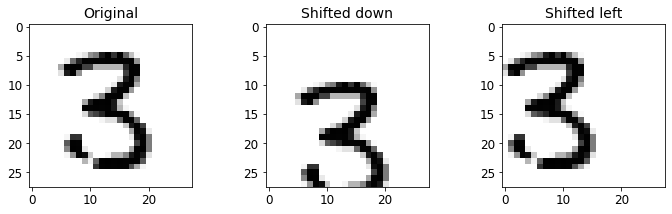

In [170]:
image = X_train[1000]
shifted_image_down = shift_image(image, 0, 5)
shifted_image_left = shift_image(image, -5, 0)

plt.figure(figsize=(12,3))
plt.subplot(131)
plt.title("Original", fontsize=14)
plt.imshow(image.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(132)
plt.title("Shifted down", fontsize=14)
plt.imshow(shifted_image_down.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(133)
plt.title("Shifted left", fontsize=14)
plt.imshow(shifted_image_left.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.show()

In [171]:
X_train_augmented = [image for image in X_train]
y_train_augmented = [label for label in y_train]

for dx, dy in ((1, 0), (-1, 0), (0, 1), (0, -1)):
    for image, label in zip(X_train, y_train):
        X_train_augmented.append(shift_image(image, dx, dy))
        y_train_augmented.append(label)

X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)

In [172]:
shuffle_idx = np.random.permutation(len(X_train_augmented))
X_train_augmented = X_train_augmented[shuffle_idx]
y_train_augmented = y_train_augmented[shuffle_idx]

In [174]:
rnd_clf = RandomForestClassifier(**grid_search.best_params_)

In [175]:
rnd_clf.fit(X_train_augmented, y_train_augmented)

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=170,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [177]:
from sklearn.metrics import accuracy_score

y_pred = rnd_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9824